<a href="https://colab.research.google.com/github/MarshaGomez/CNN-Medical-Imaging-Analysis/blob/main/Code/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) 

Mounted at /content/gdrive


#0.1 Load Functions

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns # Grouped bar plot
import itertools
import numpy as np
import pandas as pd 
import ast #Abstract Syntax Trees
import os 
import gc # Garbage Collector

from tensorflow.keras import backend as K # Useful to free GPU and memory
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from keras import layers, optimizers, models, regularizers, metrics
from keras.models import load_model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from keras.models import Model




import scipy
import scipy.misc
from PIL import Image
BATCH_SIZE = 20
EPOCHS = 50

base_path = "/content/gdrive/My Drive/Colab Notebooks/CIDL/DL Project"
train_img_path = os.path.join(base_path, "numpy data/train_tensor.npy")
train_label_path = os.path.join(base_path, "numpy data/train_labels.npy")
test_img_path = os.path.join(base_path, "numpy data/public_test_tensor.npy")
test_label_path = os.path.join(base_path, "numpy data/public_test_labels.npy")

MODEL_PATH = os.path.join(base_path, "models/PreTrained-Masses-Calcifications/ResNet")
PLOTS_PATH = os.path.join(base_path, "plots/Masses-Calcifications")


# to produce final model report histogram 
AUC_values = []
TPR_values = []
FPR_values = []
PRECISION_values = []
SPECIFICITY_values = []

# Load Arrays from Numpy Files
def load_training():
  train_images = np.load(train_img_path)
  train_labels = np.load(train_label_path)
  test_images = np.load(test_img_path)
  test_labels = np.load(test_label_path)

  return train_images, train_labels, test_images, test_labels

def get_model_predictions(model, dataset, labels, sample_count): 
  predictions = np.zeros((sample_count,))   

  BATCH_SIZE = 1
  i = 0
  for batch, labels_batch in test_datagen.flow(dataset, labels, batch_size=BATCH_SIZE, shuffle=False):
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = model.predict(batch)
    i += 1

    if i * BATCH_SIZE  >= sample_count:
      break

    #np.where(predictions < 0.5, 0, 1)
    #predictions = np.where(predictions < 0.5, 0, 1)

  return predictions


# Remove baseline samples
def remove_baseline(tensor): 
  max_ind = int(len(tensor)/2)
  indexes = [2*i + 1 for i in range(0, max_ind)]

  return tensor[indexes]

# Interchange the dataset index
def shuffle_dataset(x, y):
  indices = tf.range(start=0, limit=tf.shape(x)[0], dtype=tf.int32)
  shuffled_indices = tf.random.shuffle(indices)

  x = tf.gather(x, shuffled_indices)
  y = tf.gather(y, shuffled_indices)

  x = x.numpy()
  y = y.numpy()

  return x, y

# split dataset into training and validation set 70-30
def split_train_val(dataset, labels):
  train_data_split = dataset[:int(0.7*len(dataset))]
  valid_data_split = dataset[int(0.7*len(dataset)):]
  train_labels_split = labels[:int(0.7*len(labels))]
  valid_labels_split = labels[int(0.7*len(labels)):]

  print(train_data_split.shape)
  print(valid_data_split.shape)
  print(train_labels_split.shape)
  print(valid_labels_split.shape)      

  return train_data_split, valid_data_split, train_labels_split, valid_labels_split

# Unify masses and calcifications 
def labels_mapping(labels):
  labels_local = np.zeros(shape=labels.shape, dtype="float32")
  idx = 0
  for label in labels:
    # Masses
    if label == 1 or label == 2:
      labels_local[idx] = 0
    # Calcifications
    else:
      labels_local[idx] = 1
    idx += 1

  return labels_local




def cross_validate(k, batch_size, num_epochs, dataset, targets, verbosity, model_path):
  #10-Fold-Cross-Validation
  num_val_samples = len(dataset) // k 
  validation_accuracies = []
  validation_losses = []
  validation_precisions = []
  validation_recalls = []
  validation_aucs = []
  model = models.load_model(os.path.join(MODEL_PATH, model_path))
  for i in range(k):
    # rigen augmented data 
    
    print("processing fold #", i)
    validation_data = dataset[i * num_val_samples : (i + 1) * num_val_samples]
    validation_labels = targets[i * num_val_samples : (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [dataset[:i * num_val_samples],
        dataset[(i + 1) * num_val_samples:]], 
        axis=0)

    partial_train_targets = np.concatenate(
        [targets[:i * num_val_samples],
        targets[(i + 1) * num_val_samples:]], 
        axis=0)

    
    
    history = model.fit(train_datagen.flow(partial_train_data, 
                                          partial_train_targets,
                                          batch_size=batch_size,
                                          shuffle=False),
                        epochs=num_epochs,
                        steps_per_epoch=len(partial_train_data) // batch_size,
                        verbose=verbosity,
                        callbacks=[GarbageCollectorCallback()])
    
    val_loss, val_acc, val_prec, val_rec, val_auc= model.evaluate(valid_datagen.flow(validation_data,
                                                          validation_labels,
                                                          batch_size=batch_size,
                                                          shuffle=False),
                                       steps=len(validation_data) // batch_size,
                                       callbacks=[GarbageCollectorCallback()])
    
    validation_accuracies.append(val_acc)
    validation_losses.append(val_loss)
    validation_precisions.append(val_prec)
    validation_recalls.append(val_rec)
    validation_aucs.append(val_auc)

    ## ADDED TO TRY AND REDUCE RAM USAGE DURING CROSS VALIDATE
    del partial_train_targets
    del partial_train_data
    del validation_data
    del validation_labels
    del history
    
  return validation_accuracies, validation_losses, validation_precisions, validation_recalls, validation_aucs


def global_contrast_normalization(X):
    X_average = np.mean(X)
    #print('Mean: ', X_average)
    X = X - X_average
    return X

# Visualization Confusion Matrix
def plot_confusion_matrix(model,
                          classes,
                          dataset, 
                          labels,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    Y_pred = model.predict(test_datagen.flow(dataset,
                                            labels,
                                            batch_size=21,
                                            shuffle=False),
                          steps=len(dataset) // BATCH_SIZE)

    np.where(Y_pred < 0.5, 0, 1)
    y_pred = np.where(Y_pred < 0.5, 0, 1)

    print('Confusion Matrix')
    cm = confusion_matrix(labels, y_pred)

    #print(cm)
    #print('Classification Report')
    print(classification_report(labels, y_pred))


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return plt


def plot_loss(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  return plt

# Visualization Data Histogram
def plot_acc(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure()
  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  return plt

# Visualization Data Histogram
def plot(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  return plt

# Visualization Detail Metric
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  plt.figure(figsize=(12,10))

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

  return plt


def plot_AUC(model, dataset, labels):
  y_pred_keras = get_model_predictions(model, dataset, labels, len(dataset))
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, y_pred_keras)
  #thresholds_keras = np.linspace(0,1,num=100)
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='CNN (area = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  #plt.show()

  return auc_keras, plt

def plot_AUC2(model, dataset, labels):
  y_pred_keras = get_model_predictions(model, dataset, labels, len(dataset))
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, y_pred_keras)
  #thresholds_keras = np.linspace(0,1,num=100)
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='CNN (area = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()


# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
      gc.collect()



print("Done")



Done


## Init Data

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#all-in-one data loading & preprocessing function 
def init_data(base_NN, GCN=True, augmentation=True):
  # Get images and labels (test, train)
  train_images, train_labels, test_images, test_labels = load_training()

  # Get abnormalities only 
  train_images = remove_baseline(train_images)
  train_labels = remove_baseline(train_labels)
  test_images = remove_baseline(test_images)
  test_labels = remove_baseline(test_labels)

  # Suffle index (Previous dataset is ordered)
  train_images, train_labels = shuffle_dataset(train_images, train_labels)

  #print("Train shape: ", train_images.shape)
  #print("Test shape: ", test_images.shape)

  #1: Mass, benign
  #2: Mass, malignant
  #3: Calcification, benign
  #4: Calcification, malignant

  #count #of masses and #of calcifications
  #unique, counts = np.unique(train_labels, return_counts=True)
  #print(unique, counts)

  #print("Benign Masses samples: \t", counts[0])
  #print("Malign Masses samples: \t", counts[1])
  #print("Benign Calc samples: \t", counts[2])
  #print("Malign Calc samples: \t", counts[3])

  #labels remapping
  train_labels = labels_mapping(train_labels)
  test_labels = labels_mapping(test_labels)

  #tensors reshaping for models training 
  train_images = train_images.reshape(train_images.shape + (1,)) #(2676, 150, 150, 1)
  test_images = test_images.reshape(test_images.shape + (1,)) #(2676, 150, 150, 1)
  #print(train_images.shape)
  #print(test_images.shape)

  # split dataset into training and validation set 70-30
  train_images_split, valid_images_split, train_labels_split, valid_labels_split = split_train_val(train_images, train_labels)  

  # All images will be rescaled by 1./65535
  if  base_NN == "VGG16":
    from tensorflow.keras.applications.vgg16 import preprocess_input
  if base_NN == "ResNet50":
    from tensorflow.keras.applications.resnet import preprocess_input
  #if Inception no preprocess function 
  if base_NN == "InceptionV3":
    train_datagen = ImageDataGenerator(rescale=1./65535)
    valid_datagen = ImageDataGenerator(rescale=1./65535)
    test_datagen = ImageDataGenerator(rescale=1./65535) 

  if "InceptionV3" not in base_NN:
    train_datagen = ImageDataGenerator(rescale=1./65535, preprocessing_function=preprocess_input)
    valid_datagen = ImageDataGenerator(rescale=1./65535, preprocessing_function=preprocess_input)
    test_datagen = ImageDataGenerator(rescale=1./65535, preprocessing_function=preprocess_input) 

  if GCN:
    train_images_split_gcn = np.zeros(train_images_split.shape)  
    train_labels_split_gcn = np.zeros(train_labels_split.shape)
    valid_images_split_gcn = np.zeros(valid_images_split.shape)
    valid_labels_split_gcn = np.zeros(valid_labels_split.shape)
    train_datagen = ImageDataGenerator()
    valid_datagen = ImageDataGenerator()
    #global contrast normalization 
    counter = 0
    for image, label in train_datagen.flow(train_images_split, train_labels_split, batch_size=1, shuffle=False):
      #nomalize image
      norm_image = global_contrast_normalization(image)
      train_images_split_gcn[counter] = norm_image
      train_labels_split_gcn[counter] = label
      
      counter += 1
      if counter == len(train_images_split):
        break
    
    counter = 0
    for image, label in valid_datagen.flow(valid_images_split, valid_labels_split, batch_size=1, shuffle=False):
      #nomalize image
      norm_image = global_contrast_normalization(image)
      valid_images_split_gcn[counter] = norm_image
      valid_labels_split_gcn[counter] = label
      
      counter += 1
      if counter == len(valid_images_split):
        break
    if base_NN == "InceptionV3":  
      train_datagen = ImageDataGenerator(rescale=1./np.max(train_images_split_gcn))
      valid_datagen = ImageDataGenerator(rescale=1./np.max(valid_images_split_gcn))     
    else:
      train_datagen = ImageDataGenerator(rescale=1./np.max(train_images_split_gcn), preprocessing_function=preprocess_input)
      valid_datagen = ImageDataGenerator(rescale=1./np.max(valid_images_split_gcn), preprocessing_function=preprocess_input)      

  if GCN and augmentation:
    if base_NN == "InceptionV3":
      train_datagen = ImageDataGenerator(
          rescale=1./np.max(train_images_split_gcn),
          rotation_range=40,
          width_shift_range=0.25,
          height_shift_range=0.25,
          shear_range=20,
          zoom_range=(0.5,1.5),
          horizontal_flip=True,
          fill_mode='nearest')
    else:
      train_datagen = ImageDataGenerator(
          rescale=1./np.max(train_images_split_gcn),
          preprocessing_function=preprocess_input,
          rotation_range=40,
          width_shift_range=0.25,
          height_shift_range=0.25,
          shear_range=20,
          zoom_range=(0.5,1.5),
          horizontal_flip=True,
          fill_mode='nearest')

  if not GCN and augmentation:
    if base_NN == "InceptionV3":
      train_datagen = ImageDataGenerator(
          rescale=1./65535,
          rotation_range=40,
          width_shift_range=0.25,
          height_shift_range=0.25,
          shear_range=20,
          zoom_range=(0.5,1.5),
          horizontal_flip=True,
          fill_mode='nearest')
    else:
      train_datagen = ImageDataGenerator(
          rescale=1./65535,
          preprocessing_function=preprocess_input,
          rotation_range=40,
          width_shift_range=0.25,
          height_shift_range=0.25,
          shear_range=20,
          zoom_range=(0.5,1.5),
          horizontal_flip=True,
          fill_mode='nearest')

  print("Done")
  if GCN:
    #reshape to expand grayscale to rgb
    train_images_split_gcn = np.repeat(train_images_split, 3, axis = 3)
    valid_images_split_gcn = np.repeat(valid_images_split, 3, axis = 3)
    return train_images_split_gcn, valid_images_split_gcn, train_labels_split_gcn, valid_labels_split_gcn, train_datagen, valid_datagen, test_datagen
  else:
    #reshape to expand grayscale to rgb
    train_images_split = np.repeat(train_images_split, 3, axis = 3)
    valid_images_split = np.repeat(valid_images_split, 3, axis = 3)
    return train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen



# 0.2 Set Metrics and Global Variables

In [ ]:
INPUT_SHAPE = (150, 150, 3)
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 20


METRICS = [
      metrics.BinaryAccuracy(name='acc'),
      #metrics.Precision(name='precision'),
      #metrics.Recall(name='recall'),
      #metrics.AUC(name='auc'),
      # metrics.TruePositives(name='tp'),
      # metrics.FalsePositives(name='fp'),
      # metrics.TrueNegatives(name='tn'),
      # metrics.FalseNegatives(name='fn'),     
]

es = tf.keras.callbacks.EarlyStopping(
     monitor='val_loss', patience=20, verbose=0,
     mode='auto', restore_best_weights=True
)

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
      gc.collect()

print("Done")

Done


# Architecture : Flatten/GlobalAveragePooling, Dense 256

## Flatten, all trainable

In [ ]:
from keras.applications import ResNet50V2
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = ResNet50V2(weights='imagenet',
                     include_top=False,
                     input_shape=(150, 150, 3))

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
train_images, train_labels, test_images, test_labels = load_training()
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="ResNet50", GCN=False, augmentation=True)

test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)
test_labels = labels_mapping(test_labels)
test_images, test_labels = shuffle_dataset(test_images, test_labels)
test_images = test_images.reshape(test_images.shape + (1,))

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True,
    verbose = 1)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=15,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights('checkpoint.h5')

#unfreeze last convolutional block
#conv_base.trainable = True

for layer in model.layers:
  layer.trainable = True

print(conv_base.layers)

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),  #lr=1e-3
              metrics=METRICS)


#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])
print('done')
model.load_weights('checkpoint.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 36,672,513
Trainable params: 13,107,713
Non-trainable params: 23,564,800
_________________________________________________________________
Epoch 1/15
93/93 [==============================] - 15s 131ms/step - loss: 5.1333 - acc: 0.5486 - val_loss: 1.3054 - val_acc: 0.5350

Epoch 00001: val_loss improved from inf to 1.30538, saving model to checkpoint.h5
Epoch 2/15
93/9

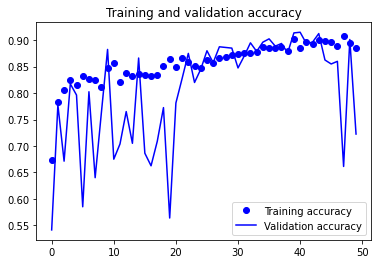

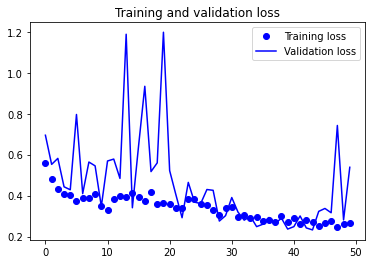

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

16/16 [==============================] - 1s 35ms/step - loss: 0.2588 - acc: 0.8938

---------------------------------
Accuracy: 89.38 %
---------------------------------

Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90       179
         1.0       0.89      0.89      0.89       157

    accuracy                           0.90       336
   macro avg       0.90      0.90      0.90       336
weighted avg       0.90      0.90      0.90       336



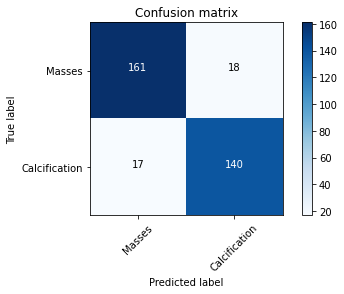

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

#print confusion matrix
classes = ["Masses", "Calcification"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
#plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))


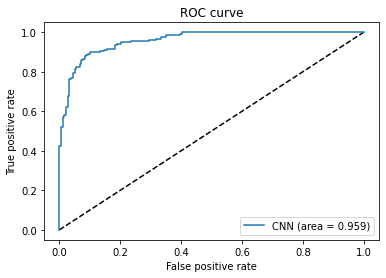

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
models.save_model(model, os.path.join(MODEL_PATH, 'ResNet_flatten_dense_256_all_trainable.h5'))

In [ ]:
#free RAM 
del model
del conv_base
del history
!rm 'checkpoint.h5'

NameError: ignored

## GlobalAveragePooling, all Trainable


In [ ]:
from keras.applications import ResNet50V2
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = ResNet50V2(weights='imagenet',
                     include_top=False,
                     input_shape=(150, 150, 3))

#conv_base.summary()

In [ ]:
train_images, train_labels, test_images, test_labels = load_training()
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="ResNet50", GCN=False, augmentation=True)

test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)
test_labels = labels_mapping(test_labels)
test_images, test_labels = shuffle_dataset(test_images, test_labels)
test_images = test_images.reshape(test_images.shape + (1,))

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True,
    verbose = 1)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=15,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights('checkpoint.h5')

#unfreeze last convolutional block
#conv_base.trainable = True

for layer in model.layers:
  layer.trainable = True

print(conv_base.layers)

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),  #lr=1e-3
              metrics=METRICS)


#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])
print('done')
model.load_weights('checkpoint.h5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 24,089,601
Trainable params: 524,801
Non-trainable params: 23,564,800
_________________________________________________________________
Epoch 1/15
93/93 [==============================] - 16s 132ms/step - loss: 0.6068 - acc: 0.7596 - val_loss: 0.4260 - val_acc: 0.8250

Epoch 00001: val_loss improved from inf to 0.42597, saving model to checkpoint.h5
Epoch 2/15
93/93 [

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

#print confusion matrix
classes = ["Masses", "Calcification"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
#plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))


In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
#free RAM 
del model
del conv_base
del history
!rm 'checkpoint_2.h5'

NameError: ignored

## Flatten, Last 2 Blocks Trainable

In [ ]:
from keras.applications import ResNet50V2
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = ResNet50V2(weights='imagenet',
                     include_top=False,
                     input_shape=(150, 150, 3))

#conv_base.summary()

In [ ]:
train_images, train_labels, test_images, test_labels = load_training()

train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="ResNet50", GCN=False, augmentation=True)


test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)
test_labels = labels_mapping(test_labels)
test_images, test_labels = shuffle_dataset(test_images, test_labels)
test_images = test_images.reshape(test_images.shape + (1,))

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True,
    verbose = 1)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=15,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights('checkpoint.h5')

#unfreeze last 2 convolutional block
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "conv5_block2_preact_bn":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

print(conv_base.layers)

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),  #lr=1e-4
              metrics=METRICS)


#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])
print('done')
model.load_weights('checkpoint.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 36,672,513
Trainable params: 13,107,713
Non-trainable params: 23,564,800
_________________________________________________________________
Epoch 1/15
93/93 [==============================] - 15s 133ms/step - loss: 1.7999 - acc: 0.7806 - val_loss: 0.5066 - val_acc: 0.7425

Epoch 00001: val_loss improved from inf to 0.50664, saving model to checkpoint.h5
Epoch 2/15
93/9

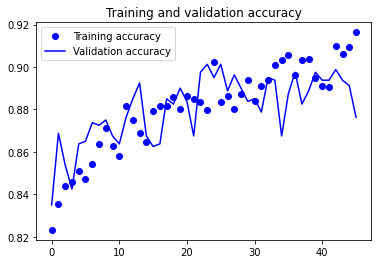

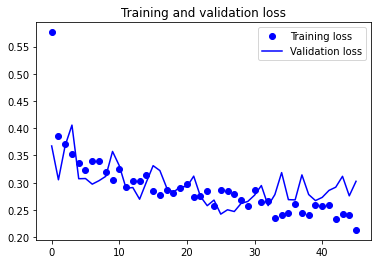

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

16/16 [==============================] - 1s 34ms/step - loss: 0.2587 - acc: 0.8938

---------------------------------
Accuracy: 89.38 %
---------------------------------

Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.92      0.87      0.90       179
         1.0       0.86      0.92      0.89       157

    accuracy                           0.89       336
   macro avg       0.89      0.89      0.89       336
weighted avg       0.89      0.89      0.89       336



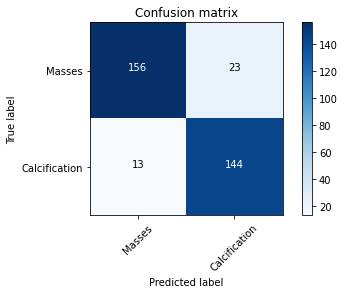

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

#print confusion matrix
classes = ["Masses", "Calcification"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
#plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))


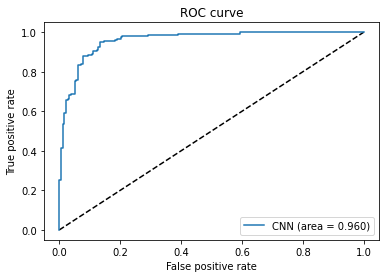

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
models.save_model(model, os.path.join(MODEL_PATH, 'resNet_dense_256x1_last_2_blocks_trainable.h5'))

In [ ]:
#free RAM 
del model
del conv_base
del history
!rm 'checkpoint.h5'

## GlobalAveragePooling, Last 2 Blocks Trainable

In [ ]:
from keras.applications import ResNet50V2
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = ResNet50V2(weights='imagenet',
                     include_top=False,
                     input_shape=(150, 150, 3))

#conv_base.summary()

In [ ]:
train_images, train_labels, test_images, test_labels = load_training()

train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="ResNet50", GCN=False, augmentation=True)


test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)
test_labels = labels_mapping(test_labels)
test_images, test_labels = shuffle_dataset(test_images, test_labels)
test_images = test_images.reshape(test_images.shape + (1,))

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True,
    verbose = 1)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=15,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights('checkpoint.h5')

#unfreeze last convolutional block
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "conv5_block2_preact_bn":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

print(conv_base.layers)

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),  #lr=1e-4
              metrics=METRICS)


#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])
print('done')
model.load_weights('checkpoint.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 24,089,601
Trainable params: 524,801
Non-trainable params: 23,564,800
_________________________________________________________________
Epoch 1/15
93/93 [==============================] - 15s 138ms/step - loss: 0.5461 - acc: 0.7871 - val_loss: 0.4276 - val_acc: 0.8050

Epoch 00001: val_loss improved from inf to 0.42763, saving model to checkpoint.h5
Epoch 2/15
93/93 [

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

#print confusion matrix
classes = ["Masses", "Calcification"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
#plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))


In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
models.save_model(model, os.path.join(MODEL_PATH, 'vgg__globalAvgPool_dense_256x1_last_2_blocks_trainable.h5'))

In [ ]:
#free RAM 
del model
del conv_base
del history
!rm 'checkpoint.h5'

## BEST - Flatten, Last 3 Blocks Trainable

In [ ]:
from keras.applications import ResNet50V2
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = ResNet50V2(weights='imagenet',
                     include_top=False,
                     input_shape=(150, 150, 3))

#conv_base.summary()

In [ ]:
train_images, train_labels, test_images, test_labels = load_training()

train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="ResNet50", GCN=False, augmentation=True)


test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)
test_labels = labels_mapping(test_labels)
test_images, test_labels = shuffle_dataset(test_images, test_labels)
test_images = test_images.reshape(test_images.shape + (1,))

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True,
    verbose = 1)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=15,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights('checkpoint.h5')

#unfreeze last convolutional block
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "block3_conv1":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

print(conv_base.layers)

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),  #lr=1e-4
              metrics=METRICS)


#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])
print('done')
model.load_weights('checkpoint.h5')

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

#print confusion matrix
classes = ["Masses", "Calcification"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
#plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))


In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
models.save_model(model, os.path.join(MODEL_PATH, 'vgg_dense_256x1_last_3_blocks_trainable.h5'))

In [ ]:
#free RAM 
del model
del conv_base
del history
!rm 'checkpoint.h5'

## GlobalAveragePooling, Last 3 Blocks Trainable


In [ ]:
from keras.applications import ResNet50V2
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = ResNet50V2(weights='imagenet',
                     include_top=False,
                     input_shape=(150, 150, 3))

#conv_base.summary()

In [ ]:
train_images, train_labels, test_images, test_labels = load_training()

train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="ResNet50", GCN=False, augmentation=True)


test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)
test_labels = labels_mapping(test_labels)
test_images, test_labels = shuffle_dataset(test_images, test_labels)
test_images = test_images.reshape(test_images.shape + (1,))

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True,
    verbose = 1)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=15,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights('checkpoint.h5')

#unfreeze last convolutional block
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "block3_conv1":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

print(conv_base.layers)

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),  #lr=1e-4
              metrics=METRICS)


#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])
print('done')
model.load_weights('checkpoint.h5')

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

#print confusion matrix
classes = ["Masses", "Calcification"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
#plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))


In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
models.save_model(model, os.path.join(MODEL_PATH, 'vgg__globalAvgPool_dense_256x1_last_3_blocks_trainable.h5'))

In [ ]:
#free RAM 
del model
del conv_base
del history
!rm 'checkpoint.h5'

# Architecture : Flatten/GlobalAveragePooling, 3x [ DropOut(0.5 + Dense (256)]

## Flatten, all trainable

In [ ]:
from keras.applications import ResNet50V2
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = ResNet50V2(weights='imagenet',
                     include_top=False,
                     input_shape=(150, 150, 3))

conv_base.summary()

In [ ]:
train_images, train_labels, test_images, test_labels = load_training()
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="ResNet50", GCN=False, augmentation=True)

test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)
test_labels = labels_mapping(test_labels)
test_images, test_labels = shuffle_dataset(test_images, test_labels)
test_images = test_images.reshape(test_images.shape + (1,))

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint_2.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True,
    verbose = 1)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=15,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights('checkpoint_2.h5')

#unfreeze last convolutional block
#conv_base.trainable = True

for layer in model.layers:
  layer.trainable = True

print(conv_base.layers)

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-3),  #lr=1e-3
              metrics=METRICS)


#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])
print('done')
model.load_weights('checkpoint_2.h5')

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

#print confusion matrix
classes = ["Masses", "Calcification"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
#plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))


In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
#free RAM 
del model
del conv_base
del history
!rm 'checkpoint_2.h5'

## GlobalAveragePooling, all Trainable


In [ ]:
from keras.applications import ResNet50V2
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = ResNet50V2(weights='imagenet',
                     include_top=False,
                     input_shape=(150, 150, 3))

#conv_base.summary()

In [ ]:
train_images, train_labels, test_images, test_labels = load_training()
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="ResNet50", GCN=False, augmentation=True)

test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)
test_labels = labels_mapping(test_labels)
test_images, test_labels = shuffle_dataset(test_images, test_labels)
test_images = test_images.reshape(test_images.shape + (1,))

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint_2.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True,
    verbose = 1)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=15,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights('checkpoint_2.h5')

#unfreeze last convolutional block
#conv_base.trainable = True

for layer in model.layers:
  layer.trainable = True

print(conv_base.layers)

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-3),  #lr=1e-3
              metrics=METRICS)


#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])
print('done')
model.load_weights('checkpoint_2.h5')

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

#print confusion matrix
classes = ["Masses", "Calcification"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
#plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))


In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
#free RAM 
del model
del conv_base
del history
!rm 'checkpoint_2.h5'

## Flatten, Last 2 Blocks Trainable

In [ ]:
from keras.applications import ResNet50V2
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = ResNet50V2(weights='imagenet',
                     include_top=False,
                     input_shape=(150, 150, 3))

#conv_base.summary()

In [ ]:
train_images, train_labels, test_images, test_labels = load_training()

train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="ResNet50", GCN=False, augmentation=True)


test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)
test_labels = labels_mapping(test_labels)
test_images, test_labels = shuffle_dataset(test_images, test_labels)
test_images = test_images.reshape(test_images.shape + (1,))

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True,
    verbose = 1)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=15,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights('checkpoint.h5')

#unfreeze last convolutional block
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "block4_conv1":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

print(conv_base.layers)

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),  #lr=1e-4
              metrics=METRICS)


#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])
print('done')
model.load_weights('checkpoint.h5')

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

#print confusion matrix
classes = ["Masses", "Calcification"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
#plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))


In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
models.save_model(model, os.path.join(MODEL_PATH, 'vgg_dense_256x1_last_2_blocks_trainable.h5'))

In [ ]:
#free RAM 
del model
del conv_base
del history
!rm 'checkpoint.h5'

## GlobalAveragePooling, Last 2 Blocks Trainable

In [ ]:
from keras.applications import ResNet50V2
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = ResNet50V2(weights='imagenet',
                     include_top=False,
                     input_shape=(150, 150, 3))

#conv_base.summary()

In [ ]:
train_images, train_labels, test_images, test_labels = load_training()

train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="ResNet50", GCN=False, augmentation=True)


test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)
test_labels = labels_mapping(test_labels)
test_images, test_labels = shuffle_dataset(test_images, test_labels)
test_images = test_images.reshape(test_images.shape + (1,))

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True,
    verbose = 1)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=15,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights('checkpoint.h5')

#unfreeze last convolutional block
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "block4_conv1":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

print(conv_base.layers)

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),  #lr=1e-4
              metrics=METRICS)


#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])
print('done')
model.load_weights('checkpoint.h5')

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

#print confusion matrix
classes = ["Masses", "Calcification"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
#plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))


In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
models.save_model(model, os.path.join(MODEL_PATH, 'vgg__globalAvgPool_dense_256x1_last_2_blocks_trainable.h5'))

In [ ]:
#free RAM 
del model
del conv_base
del history
!rm 'checkpoint.h5'

## BEST - Flatten, Last 3 Blocks Trainable

In [ ]:
from keras.applications import ResNet50V2
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = ResNet50V2(weights='imagenet',
                     include_top=False,
                     input_shape=(150, 150, 3))

#conv_base.summary()

In [ ]:
train_images, train_labels, test_images, test_labels = load_training()

train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="ResNet50", GCN=False, augmentation=True)


test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)
test_labels = labels_mapping(test_labels)
test_images, test_labels = shuffle_dataset(test_images, test_labels)
test_images = test_images.reshape(test_images.shape + (1,))

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True,
    verbose = 1)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=15,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights('checkpoint.h5')

#unfreeze last convolutional block
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "block3_conv1":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

print(conv_base.layers)

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),  #lr=1e-4
              metrics=METRICS)


#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])
print('done')
model.load_weights('checkpoint.h5')

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

#print confusion matrix
classes = ["Masses", "Calcification"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
#plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))


In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
models.save_model(model, os.path.join(MODEL_PATH, 'vgg_dense_256x1_last_3_blocks_trainable.h5'))

In [ ]:
#free RAM 
del model
del conv_base
del history
!rm 'checkpoint.h5'

## GlobalAveragePooling, Last 3 Blocks Trainable


In [ ]:
from keras.applications import ResNet50V2
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = ResNet50V2(weights='imagenet',
                     include_top=False,
                     input_shape=(150, 150, 3))

#conv_base.summary()

In [ ]:
train_images, train_labels, test_images, test_labels = load_training()

train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="ResNet50", GCN=False, augmentation=True)


test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)
test_labels = labels_mapping(test_labels)
test_images, test_labels = shuffle_dataset(test_images, test_labels)
test_images = test_images.reshape(test_images.shape + (1,))

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True,
    verbose = 1)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=15,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights('checkpoint.h5')

#unfreeze last convolutional block
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "block3_conv1":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

print(conv_base.layers)

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),  #lr=1e-4
              metrics=METRICS)


#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])
print('done')
model.load_weights('checkpoint.h5')

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

#print confusion matrix
classes = ["Masses", "Calcification"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
#plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))


In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
models.save_model(model, os.path.join(MODEL_PATH, 'vgg__globalAvgPool_dense_256x1_last_3_blocks_trainable.h5'))

In [ ]:
#free RAM 
del model
del conv_base
del history
!rm 'checkpoint.h5'